# Remarks

* Data normalization
    * Mobilenet expects data from -1 to 1
        * Normalize Input Data or Include in Model
        * TFLite Conversion must fit according to decision
    * Ground Truth Data: for better inspection Data multiplied by 80. Undo the change in the Data Input Pipeline
* Overview in Tutorials:
    * tf.function
    * Repeat addapted Version of using Build in methods for training, ...
    * Save models using keras
        * CaseNet first real model: check in implementation of Frey if a Layer needs to be written
        * other Example: depth seperable dilated convolution,
* Idea
    * Loss
        * Focal Loss: for imbalanced Data
        * In general Loss: just now weight in each dependent on number of Edge Pixels

# Libraries

In [1]:
#!for a in /sys/bus/pci/devices/*; do echo 0 | sudo tee -a $a/numa_node; done

import tensorflow as tf
import numpy as np
import os
import time
from datetime import datetime
#import sys
import matplotlib.pyplot as plt




import DataProcessing.data_processing as data_processing
import Nets.backbones as backbones
import Nets.features as features
import Nets.losses as losses
import Nets.metrics as metrics
import Nets.tools as tools


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#np.set_printoptions(threshold=sys.maxsize)

# Testing

# Options

In [2]:
#tf.config.run_functions_eagerly(True)

DATA = 'SceneNet'
MODEL = 'CASENET_FOCAL_LOSS_UNWEIGHTED'
TRAIN_DS = 'Train'
TEST_DS = 'Test'
HALF = True

IMG_SIZE_HEIGHT = 1280
IMG_SIZE_WIDTH = 720
NUM_CLASSES = 3
BATCH_SIZE = 3

MAX_IMG_TRAIN = 1500
MAX_IMG_TEST = 300

CACHE = True
SEED = None
#SEED = 5

#BACKBONE = "MobileNetV2"
#BACKBONE_OUTPUT = [1,2,3,output] #keep in mind: list start with 0.
#BACKBONE_WEIGHTS = "imagenet"
#ALPHA = 0.35
BACKBONE = "RESNet50"
BACKBONE_OUTPUT = [0,1,2,4]
BACKBONE_WEIGHTS = "imagenet"
ALPHA = 1
FINE_TUNING = False
TRAINABLE_IDX = 2 # (3-1), as indexing starts at 0



#EPOCHS = 30
EPOCHS = 15
fine_tune_epochs = 10

#Model Callback
MODEL_SAVE_EPOCH_FREQ = 5
DEL_OLD_CHECKPOINTS = False

# TENSORBOARD:
TENSORBOARD = False
DEL_OLD_TENSORBOARD = True

# SAVE
SAVE = True

# LOSS
weighted_multi_label_sigmoid_edge_loss = False
if weighted_multi_label_sigmoid_edge_loss:
    beta_upper = 0.95
    beta_lower = 0.05
    class_weighted = True

focal_loss = True
if focal_loss:
    gamma=2 
    alpha=1 
    weighted_beta=True 
    #beta_upper=0.85 
    #beta_lower=0.15
    beta_upper = 0.5
    beta_lower = 0.5
    class_weighted=False
    

# All Pixels have been labeled correctly and thus we don't need to account shifted labels 
# and a protection band around the labels for the calculation of the metrics

# In the work of Frey he mentioned that state of the Art ? is 2% of diagonal. 
# He takes 1%, I sugest to take a threshold of 3 Pixels. 
#I don't think that I made more then 3 Pixel mistake in labeling and tracking. Thus this is 0.4%
THRESHOLD_EDGE_WIDTH_REAL = 3


#TESTING
test = False
if test:
    EPOCHS = 2
    MAX_IMG_TRAIN = 60
    MAX_IMG_TEST = 6

# Load Dataset, Preprocess Images and Dataset

In [3]:
tf.random.set_seed(SEED)

paths, files = data_processing.path_definitions(HALF, MODEL, DATA, TRAIN_DS, TEST_DS)

data_processing.clean_model_directories(paths, DEL_OLD_CHECKPOINTS, DEL_OLD_TENSORBOARD)

train_ds, img_count_train = data_processing.loader(paths,"TRAIN", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TRAIN)
train_ds = data_processing.dataset_processing(train_ds, cache=CACHE, shuffle=True, batch_size=BATCH_SIZE, prefetch=True, img_count=img_count_train)

test_ds, img_count_test = data_processing.loader(paths,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_ds = data_processing.dataset_processing(test_ds, cache=CACHE, shuffle=False, batch_size=BATCH_SIZE, prefetch=True, img_count=img_count_test)

#print("Memory Usage corresponds to: ",tf.config.experimental.get_memory_info('GPU:0')['current'])

MODEL
CKPT
TBLOGS
TFLITE
FIGURES
The TRAIN Dataset contains 1500 images.
The TEST Dataset contains 300 images.


2022-05-09 22:51:19.892853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 22:51:19.900115: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 22:51:19.900630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 22:51:19.901161: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Model

In [4]:
backbone, output_names = backbones.get_backbone(name=BACKBONE,weights=BACKBONE_WEIGHTS,
                                          height=IMG_SIZE_HEIGHT,width=IMG_SIZE_WIDTH,
                                          alpha=ALPHA, output_layer = BACKBONE_OUTPUT,
                                                        trainable_idx = TRAINABLE_IDX)

upsample_side_1 = tf.keras.layers.Conv2D(1, kernel_size=1, strides=(1, 1), padding='same')(backbone.output[0])
upsample_side_2 = features.side_feature_casenet(backbone.output[1],channels=1,kernel_size_transpose=4,stride_transpose=2)
upsample_side_3 = features.side_feature_casenet(backbone.output[2],channels=1,kernel_size_transpose=8,stride_transpose=4)
#upsample_side_5 = tf.image.resize(backbone.output[3],(int(IMG_SIZE_HEIGHT/16),int(IMG_SIZE_WIDTH/16)))
upsample_side_5 = features.side_feature_casenet(backbone.output[3],channels=NUM_CLASSES,kernel_size_transpose=16,stride_transpose=8,name='side5')

side_outputs = [upsample_side_1,upsample_side_2,upsample_side_3,upsample_side_5]
concat = features.shared_concatenation(side_outputs,NUM_CLASSES)

output = features.fused_classification(concat,NUM_CLASSES,name="output")

model = tf.keras.Model(inputs = backbone.input, outputs = [output,upsample_side_5])

if weighted_multi_label_sigmoid_edge_loss:
    loss = lambda y_true, y_pred : losses.weighted_multi_label_sigmoid_loss(y_true,y_pred,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
elif focal_loss:
    loss = lambda y_true, y_pred : losses.focal_loss_edges(y_true, y_pred, gamma=gamma, alpha=alpha, weighted_beta=weighted_beta,beta_lower=beta_lower,beta_upper=beta_upper, class_weighted=class_weighted)
else:
    raise ValueError("either FocalLoss or WeightedMultiLabelSigmoidLoss must be True")
    
# tf.keras.utils.plot_model(model,show_shapes = True,to_file = 'h.png')

# Compile and Train Model

In [5]:
if TENSORBOARD:
    %load_ext tensorboard
    %tensorboard --logdir /home/david/SemesterProject/Models/CASENet/logs

In [6]:
# same Loss function is applied to both outputs, thus I only pass one loss function

# learning rate schedule
base_learning_rate = 0.0015
end_learning_rate = 0.0005
decay_step = np.ceil(img_count_train / BATCH_SIZE)*EPOCHS
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

frequency = int(np.ceil(img_count_train / BATCH_SIZE)*MODEL_SAVE_EPOCH_FREQ)

logdir = os.path.join(paths['TBLOGS'], datetime.now().strftime("%Y%m%d-%H%M%S"))
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = paths["CKPT"]+ "/ckpt-loss={loss:.2f}-epoch={epoch:.2f}",save_weights_only=False,save_best_only=False,monitor="val_loss",verbose=1,save_freq= frequency),
            tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1)]

# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=loss,
              metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                  metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})

history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, callbacks=callbacks)

Epoch 1/15


2022-05-09 22:51:35.187515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1479 of 1500
2022-05-09 22:51:35.297487: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-05-09 22:51:35.883365: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


500/500 [==============================] - 195s 355ms/step - loss: 8837.0977 - output_loss: 6964.3735 - side5_loss: 1872.7208 - output_accuracy_edges: 0.9142 - f1: 0.0087 - precision: 0.0047 - recall: 0.0890 - val_loss: 8218.6592 - val_output_loss: 7425.3193 - val_side5_loss: 793.3417 - val_output_accuracy_edges: 0.9245 - val_f1: 0.0137 - val_precision: 0.0081 - val_recall: 0.0435
Epoch 2/15
500/500 [==============================] - 176s 353ms/step - loss: 1063.7979 - output_loss: 586.5161 - side5_loss: 477.2817 - output_accuracy_edges: 0.9854 - f1: 0.0955 - precision: 0.1479 - recall: 0.0707 - val_loss: 894.7232 - val_output_loss: 493.7705 - val_side5_loss: 400.9527 - val_output_accuracy_edges: 0.9860 - val_f1: 0.1629 - val_precision: 0.2783 - val_recall: 0.1151
Epoch 3/15
500/500 [==============================] - 176s 352ms/step - loss: 783.2913 - output_loss: 421.4737 - side5_loss: 361.8175 - output_accuracy_edges: 0.9867 - f1: 0.1740 - precision: 0.2930 - recall: 0.1238 - val_los

2022-05-09 23:06:03.119861: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/CASENET_FOCAL_LOSS_UNWEIGHTED/CKPT/ckpt-loss=562.21-epoch=5.00/assets
500/500 [==============================] - 184s 368ms/step - loss: 562.2093 - output_loss: 289.5353 - side5_loss: 272.6740 - output_accuracy_edges: 0.9883 - f1: 0.3020 - precision: 0.4834 - recall: 0.2196 - val_loss: 539.5163 - val_output_loss: 278.1570 - val_side5_loss: 261.3595 - val_output_accuracy_edges: 0.9884 - val_f1: 0.3666 - val_precision: 0.5383 - val_recall: 0.2779
Epoch 6/15
500/500 [==============================] - 174s 349ms/step - loss: 527.1635 - output_loss: 268.2329 - side5_loss: 258.9308 - output_accuracy_edges: 0.9888 - f1: 0.3561 - precision: 0.5383 - recall: 0.2662 - val_loss: 549.5612 - val_output_loss: 274.0397 - val_side5_loss: 275.5214 - val_output_accuracy_edges: 0.9887 - val_f1: 0.2365 - val_precision: 0.6544 - val_recall: 0.1444
Epoch 7/15
500/500 [==============================] - 174s 348ms/step - loss: 490.8427 - ou

# Plot Results

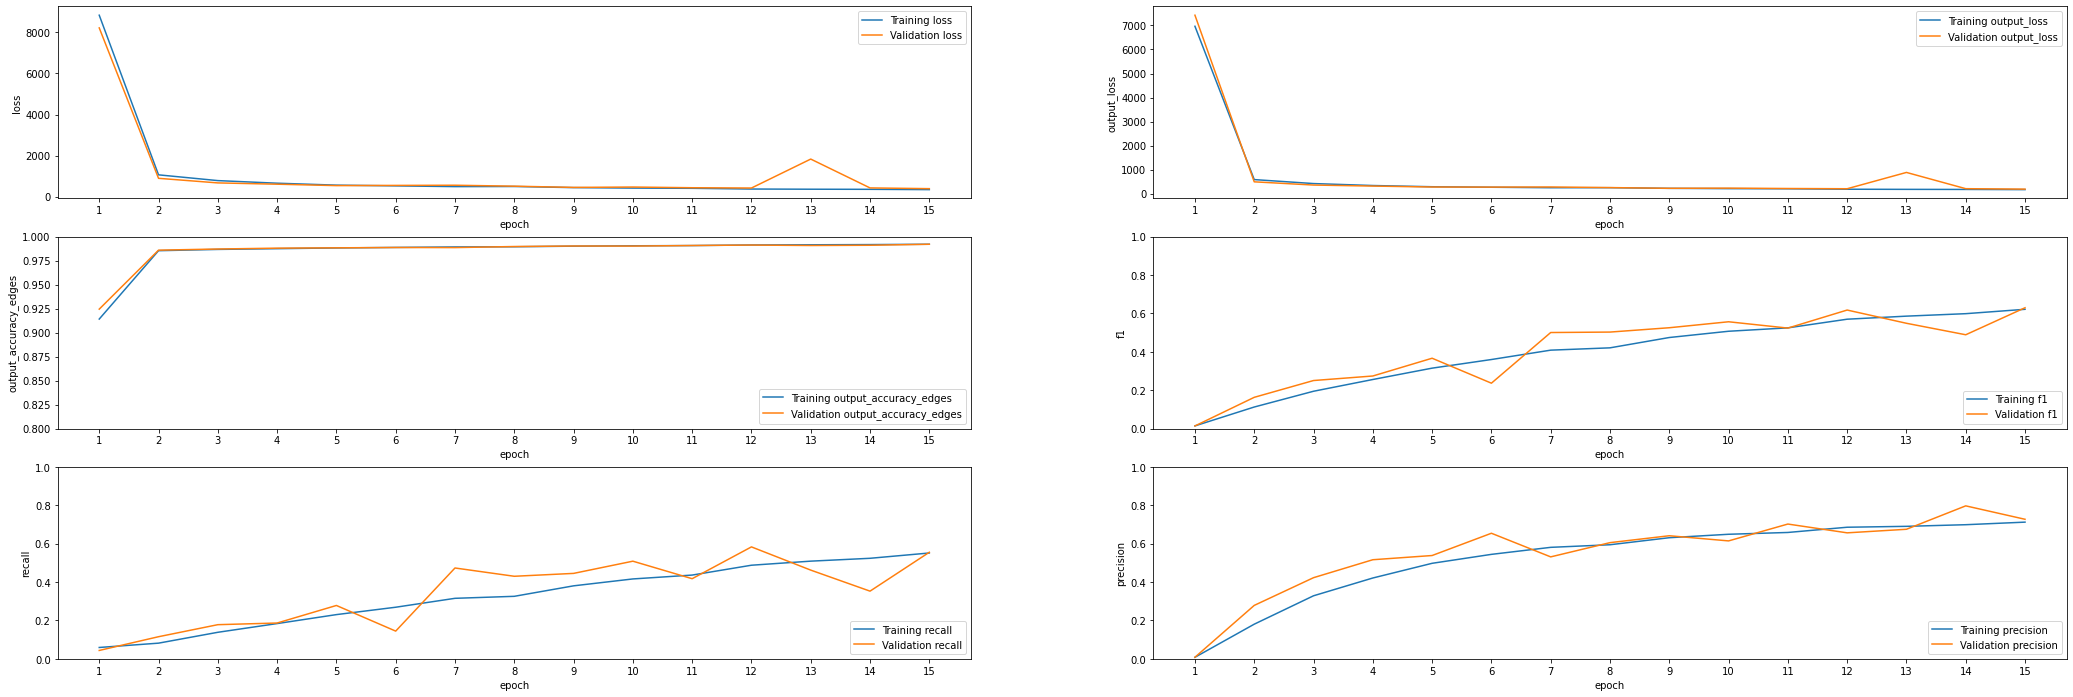

In [7]:
plot_losses = ["loss", "output_loss"]
plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]

path = os.path.join(paths["FIGURES"],"training.svg")

tools.plot_training_results(res=history.history, losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path)

/home/david/SemesterProject/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-05-09 23:35:51.968885: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Maximum F1 Score = 0.672 at threshold = 0.450
Maximum Precision Score = 0.974 at threshold = 0.800
Maximum Recall Score = 0.990 at threshold = 0.100
Maximum Accuracy Score = 0.992 at threshold = 0.500


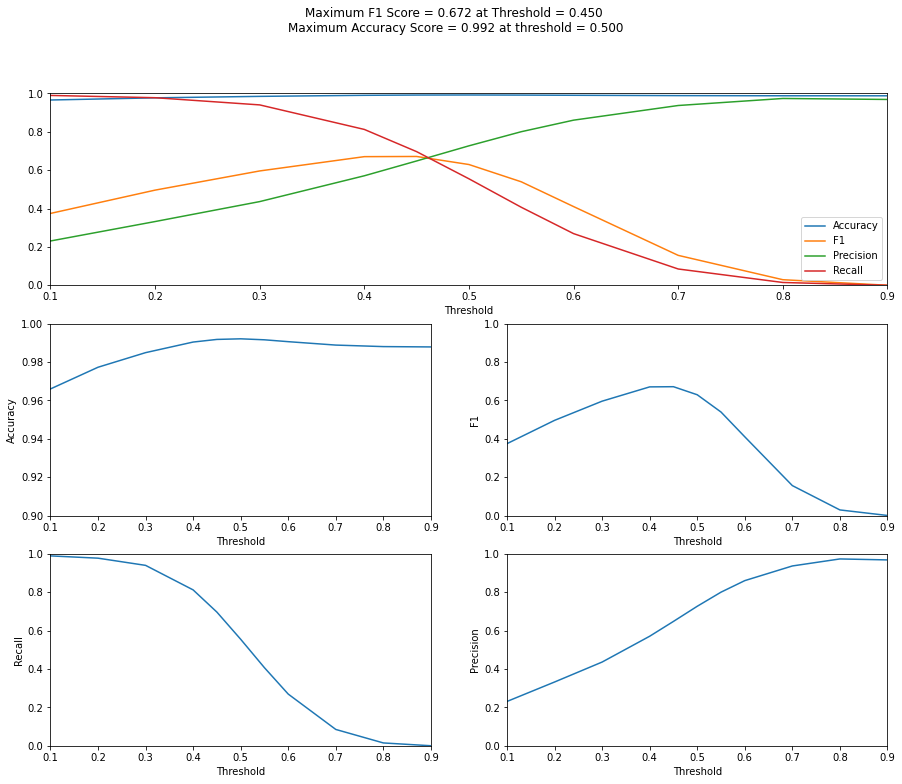

In [8]:
### Maximum F1 Score:

step_width = 0.05
threshold_range = [0.05,0.95]
threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)
threshold_array = np.array([0.1, 0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8, 0.9])

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_ds.svg")
tools.plot_threshold_metrics_evaluation(model=model, ds=test_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.9)

(3, 640, 360, 1)


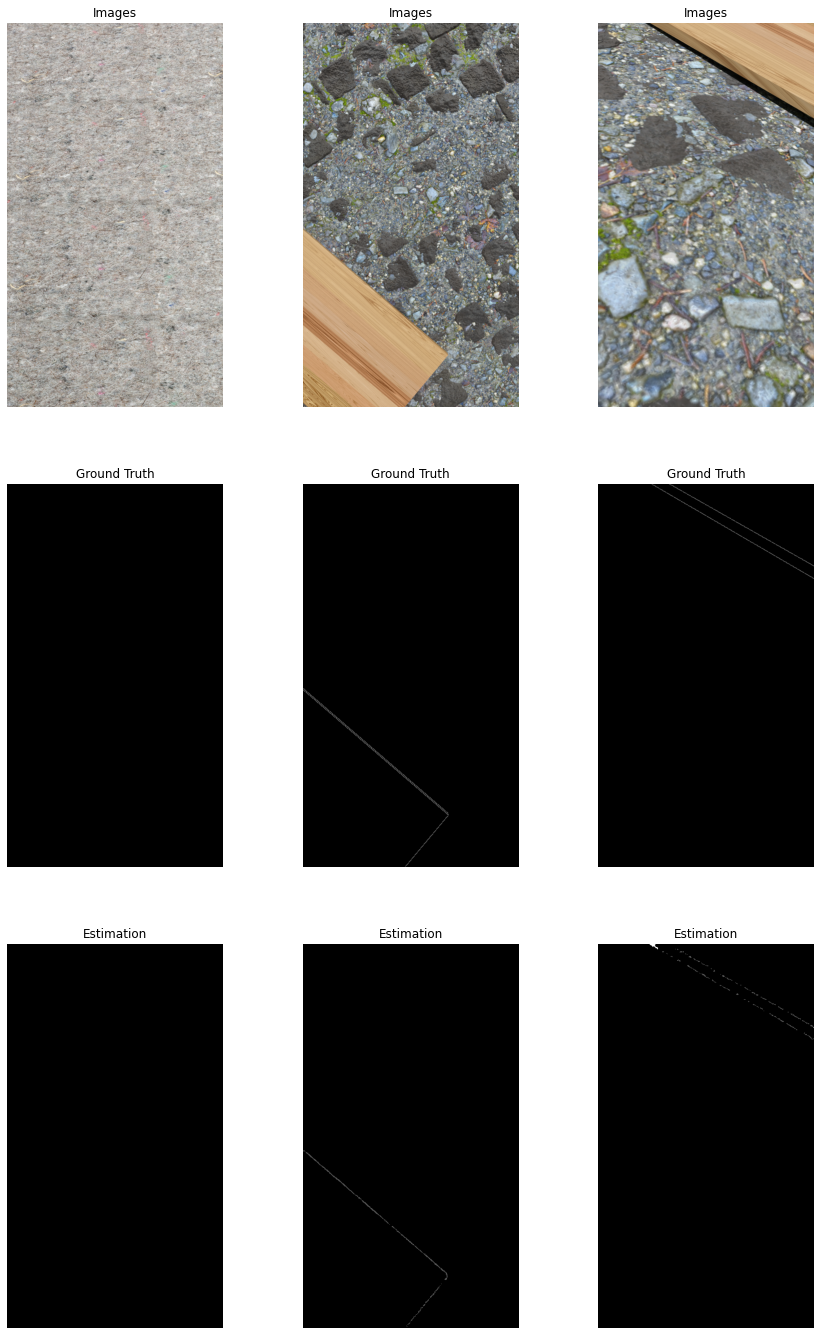

In [9]:
for img, label in test_ds.take(1):
    img, label = img, label
    
predictions = model.predict(img)
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

print(predictions.shape)

path = os.path.join(paths["FIGURES"],"images_test")
tools.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

# Fine Tuning

In [10]:
if FINE_TUNING:

    # Fine-tune from this layer onwards
    fine_tune_output = output_names[1-1]

    model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer: 
    for submodel in model.layers:
        if submodel.name == "base_model":
            for layer in submodel.layers:
                layer.trainable = False
                if layer.name == fine_tune_output:
                    break
    
    
    total_epochs =  EPOCHS + fine_tune_epochs

    base_learning_rate = 0.00001
    end_learning_rate =  0.00001
    decay_step = np.floor(img_count_train / BATCH_SIZE)*fine_tune_epochs
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
        base_learning_rate,decay_steps = decay_step,end_learning_rate = end_learning_rate, power = 0.9)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=loss,
                  metrics={'output': [metrics.BinaryAccuracyEdges(threshold_prediction=0),
                                      metrics.F1Edges(threshold_prediction=0, threshold_edge_width=0)]})
    

    history_fine = model.fit(train_ds, epochs=total_epochs, 
                               initial_epoch=history.epoch[-1]+1,validation_data=train_ds.take(1), 
                               callbacks=callbacks)
    
    plot_losses = ["loss", "output_loss"]
    plot_metrics = ["output_accuracy_edges", "f1", "recall", "precision"]
    
    path = os.path.join(paths["FIGURES"],"fine_tuning_training.svg")
    
    tools.plot_training_results(res=history.history, res_fine = history_fine.history, 
                                losses=plot_losses, metrics=plot_metrics, save=SAVE, path=path, epochs=EPOCHS)
    
    path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation__fine_tune_test_ds.svg")
    tools.plot_threshold_metrics_evaluation(model=model, ds=test_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.9)
        
    for img, label in test_ds.take(1):
        img, label = img, label

    predictions = model.predict(img)    
    predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

    path = os.path.join(paths["FIGURES"],"fine_tuning_images_0,5")
    tools.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=3)

# Evaluate on Test DS of Real Images

In [11]:
DATA_REAL = 'RealRed'
TRAIN_REAL = 'Train'
TEST_REAL = 'Test'
TEST_HARD_REAL = 'Test Hard'
IMG_ONLY_REAL = 'Img Only'
BS_REAL = 8

paths_real, files_real = data_processing.path_definitions(HALF, MODEL, DATA_REAL, TRAIN_REAL, TEST_REAL, TEST_HARD_REAL, IMG_ONLY_REAL)

test_real_ds, img_count_test_real = data_processing.loader(paths_real,"TEST", IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, HALF, MAX_IMG_TEST)
test_real_ds = data_processing.dataset_processing(test_real_ds, cache=False, shuffle=False, batch_size=BS_REAL, prefetch=False, img_count = img_count_test_real)

The TEST Dataset contains 25 images.


## Metrics Evaluation

/home/david/SemesterProject/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Maximum F1 Score = 0.226 at threshold = 0.150
Maximum Precision Score = 1.000 at threshold = 0.850
Maximum Recall Score = 0.313 at threshold = 0.100
Maximum Accuracy Score = 0.996 at threshold = 0.500


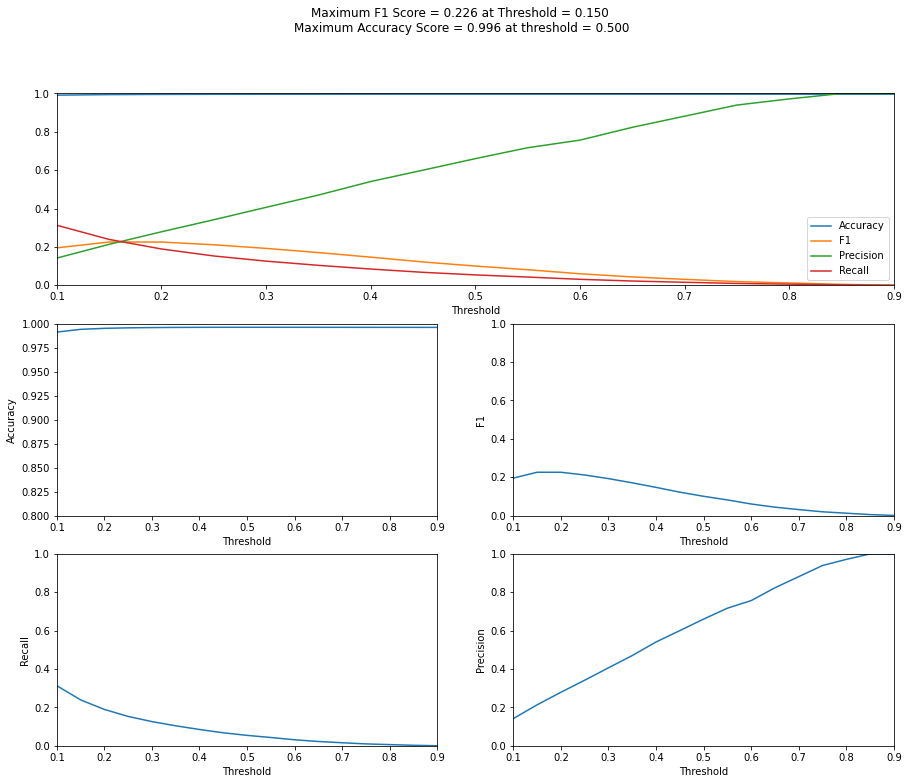

/home/david/SemesterProject/tf/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Maximum F1 Score = 1.000 at threshold = 0.750
Maximum Precision Score = 1.000 at threshold = 0.750
Maximum Recall Score = 1.000 at threshold = 0.100
Maximum Accuracy Score = 0.996 at threshold = 0.500


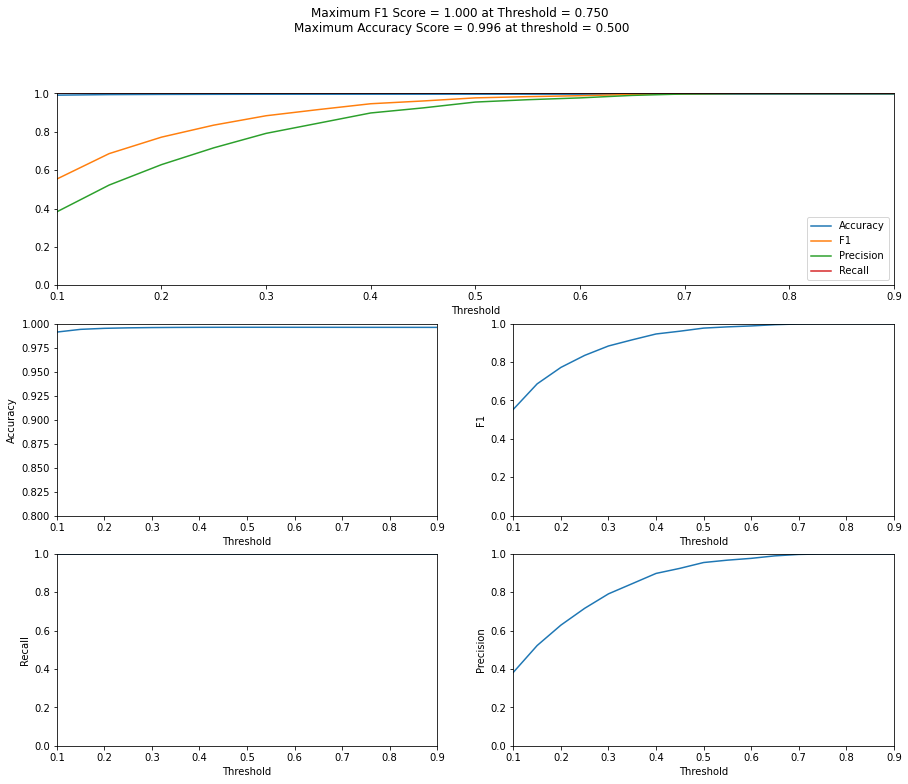

In [12]:
step_width = 0.05
threshold_range = [0.1,0.9]
threshold_array = np.arange(threshold_range[0],threshold_range[1]+step_width,step_width)

path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_real_edge_threshold_{:.1f}.svg".format(0))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_real_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=0, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)


path_metrics_evaluation_plot = os.path.join(paths["FIGURES"],"threshold_metrics_evaluation_test_real_edge_threshold_{:.1f}.svg".format(THRESHOLD_EDGE_WIDTH_REAL))
tools.plot_threshold_metrics_evaluation(model=model, ds=test_real_ds, threshold_array=threshold_array, 
                                        threshold_edge_width=THRESHOLD_EDGE_WIDTH_REAL, save=SAVE, path=path_metrics_evaluation_plot, 
                                        accuracy_y_lim_min = 0.8)

## Visual Results

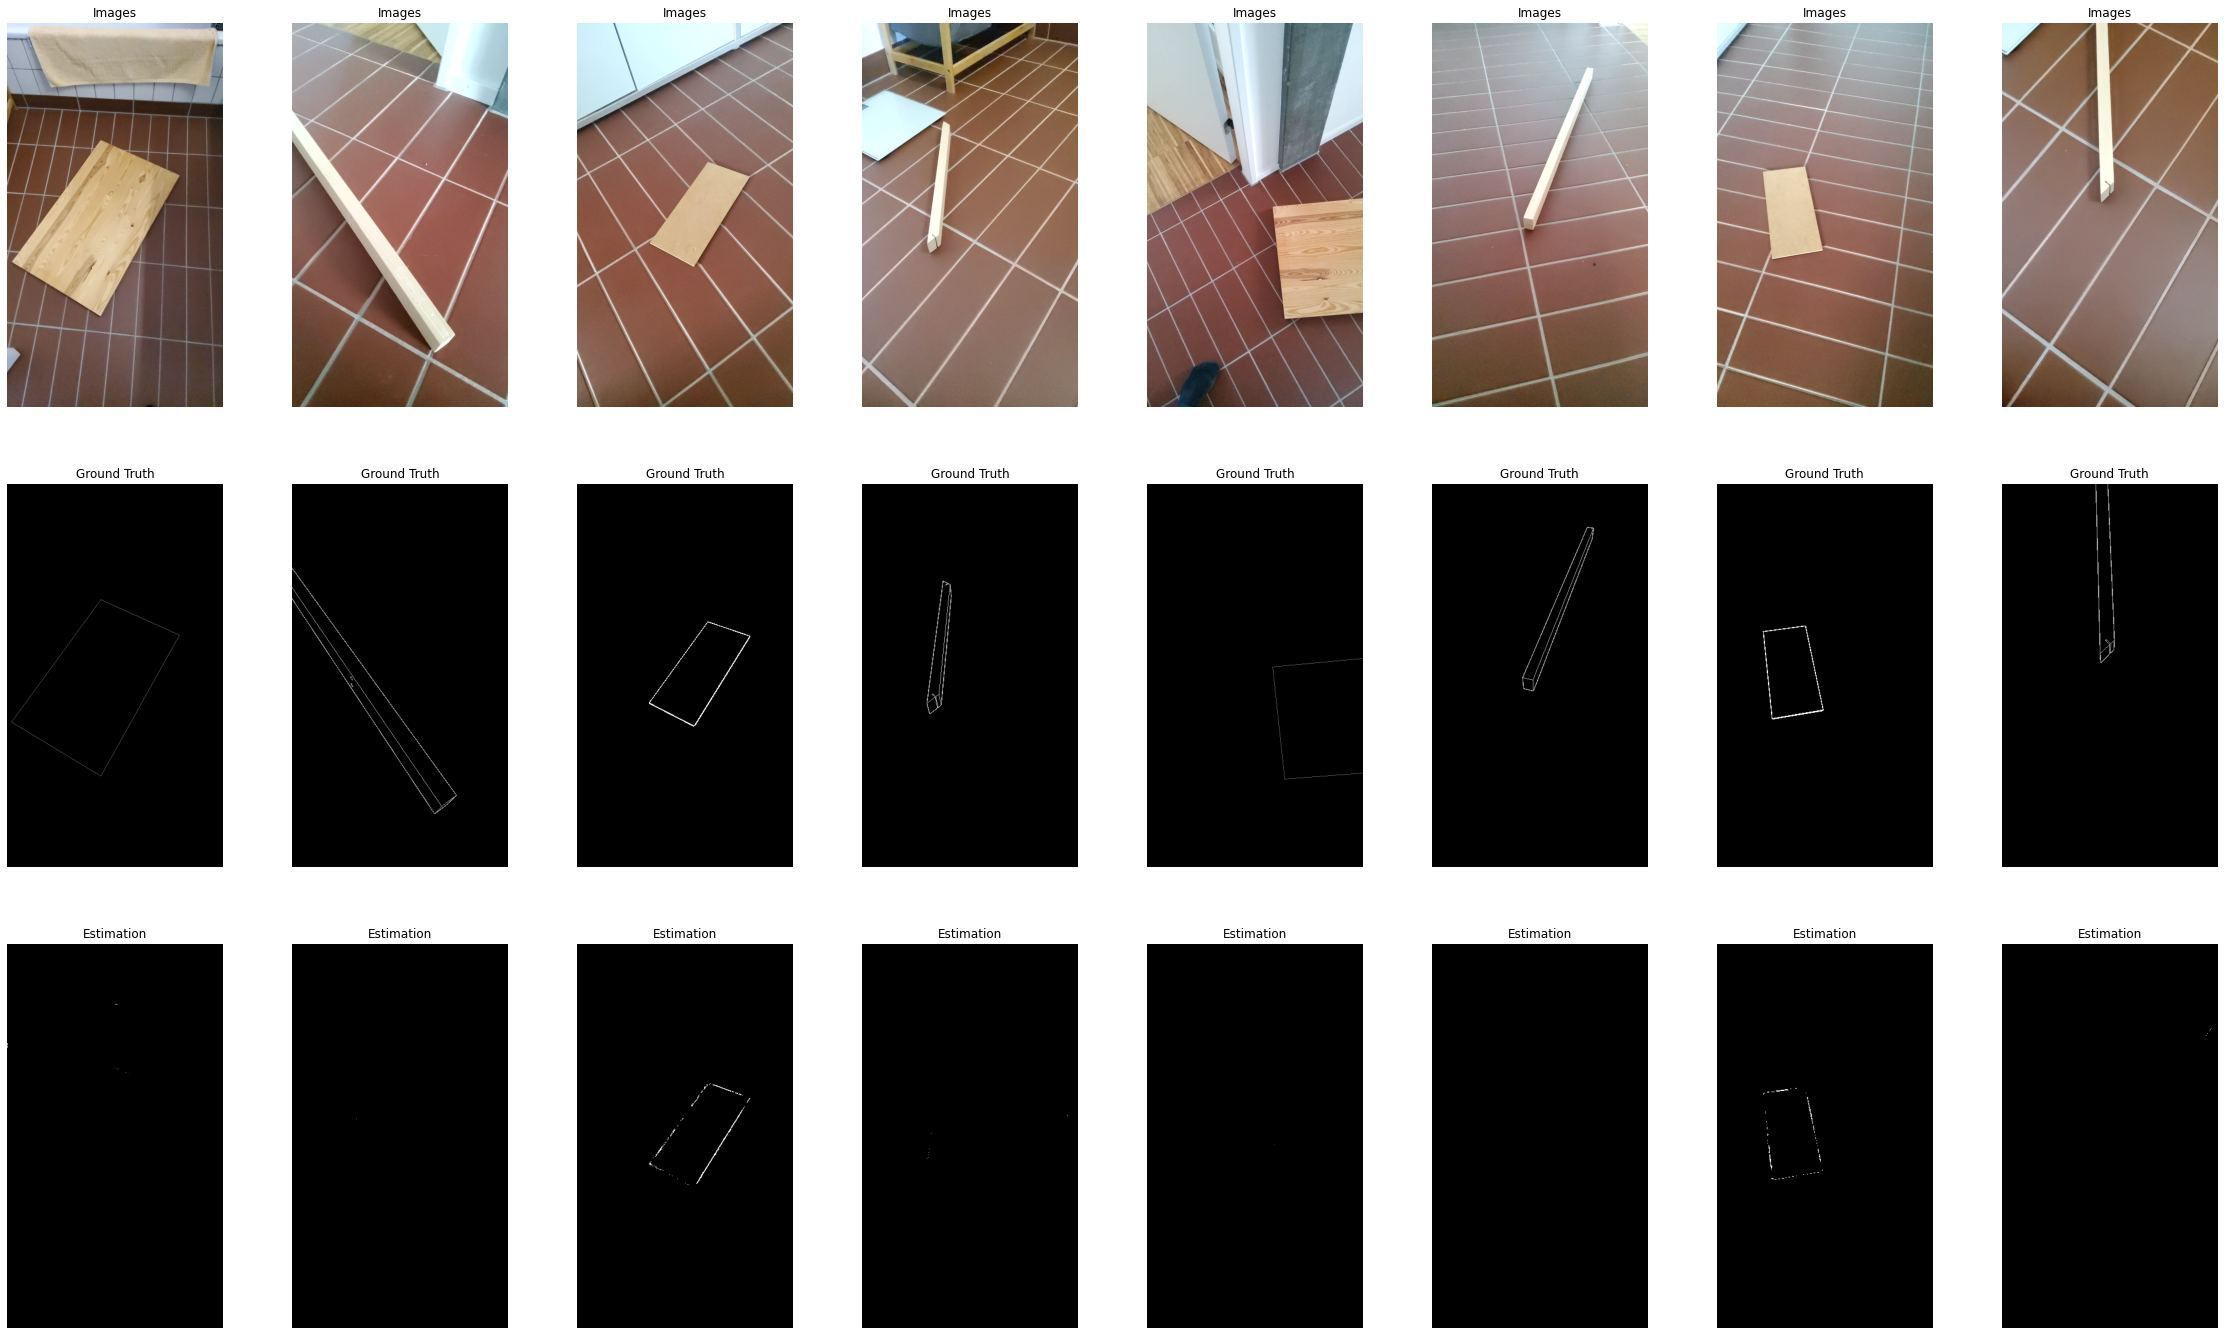

In [13]:
for img, label in test_real_ds.take(1):
    img, label = img, label

predictions = model.predict(img)    
predictions = tools.predict_class_postprocessing(predictions[0], threshold = 0.5)

path = os.path.join(paths["FIGURES"],"images_test_real")
tools.plot_images(images=img, labels=label, predictions=predictions, save=SAVE, path=path, batch_size=8)

# Save Model

In [14]:
if SAVE:
    model.save(paths["MODEL"])
    
    custom_objects = {"BinaryAccuracyEdges": metrics.BinaryAccuracyEdges,
                      "F1Edges": metrics.F1Edges,
                      "<lambda>":loss}
    
    model = tf.keras.models.load_model(paths["MODEL"], custom_objects=custom_objects)

INFO:tensorflow:Assets written to: /home/david/SemesterProject/Models/CASENET_FOCAL_LOSS_UNWEIGHTED/assets


# Plot Other, Additional Data.

# Addtional Elements to Consider in other Projects

* Data augmentation for small datasets